# Introduction
This web site is running a "Jupyter notebook," which allows you to execute interactive Octave
code directly in your browser. Each (part of a code) line preceeded by a percent symbol "%" is a code comment.

To execute any Octave commands, first enter the commands in a code cell, and then depress the "shift" and "enter" keys on your keyboard at the same time, making sure that your cursor is placed inside of the code cell.
I refer to this as "< shift \> < enter \>" in my instructions below.

The output from this notebook will be used to provide answers for this lesson's practice
quiz. As you proceed through the specialization, you will use more and more Jupyter notebooks
to write Octave code to implement battery-management-system algorithms.

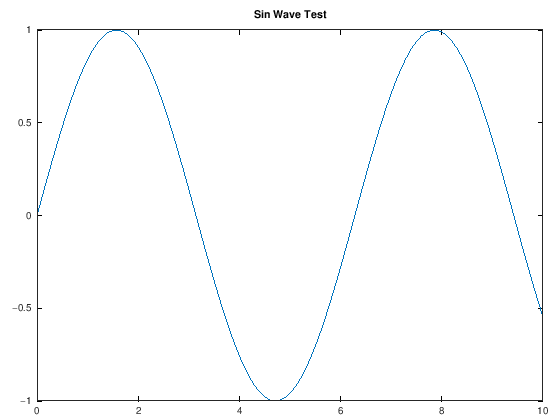

In [2]:
% Set the toolkit to gnuplot
graphics_toolkit('gnuplot')

% Force plots to be inline
set(0, 'defaultfigurevisible', 'off');

% Test plot
x = 0:0.1:10;
y = sin(x);
plot(x, y);
title('Sin Wave Test');

In [3]:
whos



Variables visible from the current scope:

variables in scope: top scope

  Attr   Name        Size                     Bytes  Class
  ====   ====        ====                     =====  ===== 
         ans         1x4                          4  char
         x           1x101                       24  double
         y           1x101                      808  double

Total is 206 elements using 836 bytes



In [20]:
% 1. Load the data (skipping the first 8 lines of headers in your CSV)
raw_data = dlmread('lifepo4_20ah.csv', ',', 10, 0);

% 2. Initialize an empty structure (This prevents the "empty structure array" error)
data = struct();

% 3. Assign the columns to the structure fields
% Column 1: Time(S), Column 2: Cur(A), Column 3: Vol(V)
data.time = raw_data(:, 1);
data.current = raw_data(:, 2);
data.voltage = raw_data(:, 3);
data.step = raw_data(:, 4);
data.disAh = raw_data(:, 5);
data.chgAh = raw_data(:, 6);

% 4. Save to the MAT file
save('lifepo4_20ah.mat', 'data');

In [21]:
% Place your cursor in this input code cell. Then, type < shift >< enter > to execute

% This loads the OCV Test Script data from storage for a 25 degC test
% load E2_OCV_P25.mat
load lifepo4_20ah.mat

In [22]:
% The variable "OCVData" has been loaded by the previous input box. Place 
% your cursor in this input code cell and depress < shift >< enter >

whos





Variables visible from the current scope:

variables in scope: top scope

  Attr   Name          Size                     Bytes  Class
  ====   ====          ====                     =====  ===== 
         IR1Ca         1x1                          8  double
         IR1D          1x1                          8  double
         IR1Da         1x1                          8  double
         IR2Ca         1x1                          8  double
         Q25           1x1                          8  double
         SOC           1x201                       24  double
         ans           1x1                          8  double
         ax            2x1                         16  double
         blend         1x6275                   50200  double
         chgZ       6275x1                      50200  double
         data          1x1                     755856  struct
         disZ       8512x1                      68096  double
         eta25         1x1                          8  

### Visualizing data
There is an enormous amount of data stored from these four cell tests. One good way to visualize the data is via plotting. For example:

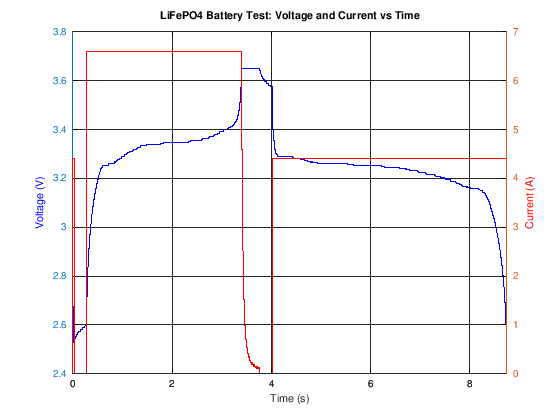

In [23]:
% 4. Plot using plotyy to create dual Y-axes
% plotyy(X1, Y1, X2, Y2)
[ax, h1, h2] = plotyy(data.time/3600, data.voltage, data.time/3600, data.current);

% 5. Customize the line styles (Optional but makes it look better)
set(h1, 'linewidth', 2, 'color', 'b'); % Voltage line (Blue)
set(h2, 'linewidth', 2, 'color', 'r'); % Current line (Red)

% 6. Add labels and title
xlabel('Time (s)', 'fontsize', 12);
ylabel(ax(1), 'Voltage (V)', 'fontsize', 12, 'color', 'b');
ylabel(ax(2), 'Current (A)', 'fontsize', 12, 'color', 'r');
title('LiFePO4 Battery Test: Voltage and Current vs Time', 'fontsize', 14);

% 7. Add grid and legend
grid on;
% legend([h1, h2], {'Voltage (V)', 'Current (A)'}, 'location', 'northeast');

### Finding coulombic efficiency
The data provided for use with this notebook are all measured at 25<sup>o</sup>C. We can use these data to find the coulombic efficiency of the cell at this temperature, as discussed in the lesson.

In [24]:
% Place your cursor in this input code cell. Then, type < shift >< enter > to execute
% 1. Open the file for reading
fid = fopen('lifepo4_20ah.csv', 'r');

% Variables to store our extracted capacities
totDisAh = 0;
totChgAh = 0;

% 2. Loop through the file line by line
while ~feof(fid)
    % Read the current line
    line = fgetl(fid);
    
    % Check if we reached the main data (so we can stop reading)
    if strncmp(line, 'Time(S)', 7)
        break; 
    end
    
    % 3. Look for step 1-3
    if strncmp(line, '*1-3', 4)
        % Split the line into parts using the comma as a delimiter
        % Example line: *1-3,C-CV,20.87,69.97
        parts = strsplit(line, ',');
        
        % The capacity is the 3rd item. Convert it from text to a number
        totChgAh = str2double(parts{3});
    end
    
    % 4. Look for step 1-5
    if strncmp(line, '*1-5', 4)
        parts = strsplit(line, ',');
        totDisAh = str2double(parts{3});
    end
end

% 5. Close the file (important to free up system resources!)
fclose(fid);

% Display the results
fprintf('Capacity for Step 1-3: %.2f Ah\n', totChgAh);
fprintf('Capacity for Step 1-5: %.2f Ah\n', totDisAh);
eta25 = totDisAh/totChgAh









































Capacity for Step 1-3: 20.87 Ah

Capacity for Step 1-5: 20.80 Ah

eta25 = 0.9966


### Finding total capacity
The total capacity (Q25) of this battery cell is equal to totDisAh of the Battery cell.

In [25]:
Q25 = totDisAh;

### Finding approximate OCV relationship at this temperature
The following code computes the approximate OCV versus SOC relationship using only the 25<sup>o</sup>C data set. The code is functionally the same as what you learned about in the lesson.














IR1D = 0.021000

IR2D = 0.052000

IR1C = 0.026000

IR2C = 0.042000














    interp1 at line 242 column 11

    interp1 at line 242 column 11


















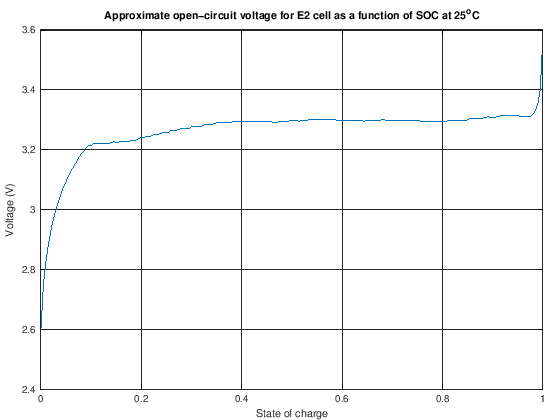

In [33]:
% Place your cursor in this input code cell. Then, type < shift >< enter > to execute
SOC = 0:0.005:1; % output SOC points for this step

%identify first 
indC  = find(data.step == 3); % slow charge
IR1Ca = data.voltage(indC(1)) - data.voltage(indC(1)-1);
IR2Ca = data.voltage(indC(end)) - data.voltage(indC(end)+1);

indD  = find(data.step == 5); % slow discharge
IR1Da = data.voltage(indD(1)-1) - data.voltage(indD(1));
IR2Da = data.voltage(indD(end)+1) - data.voltage(indD(end));

IR1D = max(IR1Da,2*IR2Ca) 
IR2D = max(IR2Da,2*IR1Ca)
IR1C = max(IR1Ca,2*IR2Da) 
IR2C = max(IR2Ca,2*IR1Da)

blend = (0:length(indD)-1)/(length(indD)-1);
IRblend = IR1D + (IR2D-IR1D)*blend(:);
disV = data.voltage(indD) + IRblend;
disZ = 1 - data.disAh(indD)/Q25;
disZ = disZ + (1 - disZ(1));

blend = (0:length(indC)-1)/(length(indC)-1);
IRblend = IR1C + (IR2C-IR1C)*blend(:);
chgV = data.voltage(indC) - IRblend;
chgZ = data.chgAh(indC)/Q25;
chgZ = chgZ - chgZ(1);

deltaV50 = interp1(chgZ,chgV,0.5) - interp1(disZ,disV,0.5);
ind = find(chgZ < 0.5);
vChg = chgV(ind) - chgZ(ind)*deltaV50;
zChg = chgZ(ind);
ind = find(disZ > 0.5);
vDis = flipud(disV(ind) + (1 - disZ(ind))*deltaV50);
zDis = flipud(disZ(ind));
rawocv = interp1([zChg; zDis],[vChg; vDis],SOC,'linear','extrap');

% At this point, the pair {SOC,rawocv} form a lookup table for the approximate OCV versus SOC relationship
% We can plot this relationship:
plot(SOC,rawocv)                
xlabel('State of charge')
ylabel('Voltage (V)') 
grid on
title('Approximate open-circuit voltage for E2 cell as a function of SOC at 25^oC')

In [34]:
indD  = find(OCVData.script1.step == 2); % slow discharge
IR1Da = OCVData.script1.voltage(indD(1)-1) - OCVData.script1.voltage(indD(1));
disp(indD(end))
OCVData.script1.voltage(indD(end)+1)
OCVData.script1.voltage(indD(end))
disp(IR1Da)


error: 'OCVData' undefined near line 1, column 14

error: 'OCVData' undefined near line 1, column 9

15746

error: 'OCVData' undefined near line 1, column 1

error: 'OCVData' undefined near line 1, column 1

0.021000


In [35]:
% Compile voltages and temperatures into arrays rather than a structure
Vraw = []; temps = [];
for k = 1: numtemps,
    if filedata(k).temp > 0,
        Vraw = [Vraw; filedata(k).rawocv]; %#ok <AGROW >
        temps = [temps;filedata(k).temp]; %#ok <AGROW >
    end
end
% Perform least - squares fit of model to data
X = [ ones(size(temps)), temps] \ Vraw;
model.OCV0 = X(1,:);
model.OCVrel = X(2,:);
model.SOC = SOC;









error: 'numtemps' undefined near line 1, column 12



error: X(1,_): out of bound 0 (dimensions are 0x0)

error: X(2,_): out of bound 0 (dimensions are 0x0)



### Table lookup
The relationship for OCV versus SOC is not yet final since we have processed only one temperature at this point. However, we can still use the computations performed to date in order to find a table-lookup approximate value of OCV as a function of SOC. 

In [38]:
% Place your cursor in this input code cell. Then, type < shift >< enter > to execute

testSOC = 0; % Replace "0.30" with whatever value of SOC for which you desire to know OCV
OCV = interp1(SOC,rawocv,testSOC)





OCV = 2.5970
